# Présentation du Notebook

Ce notebook est conçu pour analyser un corpus multilingue en utilisant des techniques avancées de traitement du langage naturel (NLP). Il intègre des méthodes pour charger des données, analyser la distribution des langues, la longueur des textes, gérer les déséquilibres des données, et effectuer la tokenisation avec des modèles de NLP modernes comme XLM-RoBERTa. L'objectif est de préparer les données pour la modélisation, d'entraîner un modèle de classification de texte et d'évaluer ses performances.

## Fonctionnalités principales :

1. **`load_data(filepath: str) -> pd.DataFrame`**
   - **Objectif** : Charger des données à partir d'un fichier CSV.
   - **Utilisation** : Cette fonction est utilisée pour importer les données qui seront analysées et manipulées tout au long du notebook. Elle convertit les données en `DataFrame` de pandas, facilitant leur manipulation avec divers outils de traitement de données en Python.

2. **`analyze_language_distribution(data: pd.DataFrame) -> pd.Series`**
   - **Objectif** : Analyser et obtenir la distribution des langues dans les données.
   - **Utilisation** : Sert à identifier la fréquence de chaque langue dans le dataset, ce qui est crucial pour comprendre la représentation des langues et planifier des interventions comme l'augmentation des données pour les langues sous-représentées.

3. **`analyze_text_length(data: pd.DataFrame) -> pd.Series`**
   - **Objectif** : Calculer et examiner la longueur des textes dans le dataset.
   - **Utilisation** : Aide à détecter les valeurs aberrantes et à comprendre la distribution de la longueur des textes, ce qui peut influencer les décisions relatives au prétraitement des données, telles que le découpage ou la segmentation des textes.

4. **`plot_distributions(data: pd.DataFrame)`**
   - **Objectif** : Afficher graphiquement les distributions des langues et des longueurs de texte.
   - **Utilisation** : Fournit une visualisation qui aide à comprendre visuellement la distribution des langues et la longueur des textes, permettant une analyse rapide et intuitive des tendances et des anomalies.

5. **`remove_text_length_outliers(data: pd.DataFrame) -> pd.DataFrame`**
   - **Objectif** : Éliminer les valeurs aberrantes basées sur la longueur des textes.
   - **Utilisation** : Nettoie le dataset en supprimant les textes qui sont trop longs ou trop courts par rapport aux normes établies, ce qui peut aider à améliorer la performance des modèles de NLP en réduisant le bruit.

6. **`augment_underrepresented_labels(data: pd.DataFrame, label_col: str, text_col: str, threshold: int) -> pd.DataFrame`**
   - **Objectif** : Augmenter les étiquettes sous-représentées pour équilibrer le dataset.
   - **Utilisation** : Augmente les classes qui ont moins d'instances que le seuil spécifié, utilisant `SMOTE` pour équilibrer le dataset et améliorer la justesse et la performance du modèle de classification.

7. **`split_train_dev_test(csv_path: str, folder_csv: str, label_column: str, train_size: float, dev_size: float, random_state: int)`**
   - **Objectif** : Diviser les données en ensembles d'entraînement, de développement, et de test.
   - **Utilisation** : Prépare les données pour le processus de modélisation en créant des sous-ensembles distincts pour l'entraînement, la validation et les tests, ce qui est essentiel pour l'évaluation rigoureuse des performances du modèle.
8. **`clean_none_values(dataset)`**
   - **Objectif** : Nettoyer les valeurs nulles dans le dataset.
   - **Utilisation** : Cette fonction permet de nettoyer les valeurs nulles dans le dataset, ce qui est une étape importante pour garantir la qualité des données utilisées pour l'entraînement et l'évaluation des modèles de NLP.
9. **`tokenize(text: str, lang: str) -> list`**
   - **Objectif** : Tokeniser un texte selon sa langue.
   - **Utilisation** : Convertit le texte en une série de tokens ou de mots, ce qui est une étape préparatoire nécessaire pour de nombreux algorithmes de NLP qui nécessitent des entrées tokenisées.

10. **`vocabulary_diversity(data: pd.DataFrame) -> pd.Series`**
   - **Objectif** : Calculer la diversité lexicale par langue.
   - **Utilisation** : Fournit des mesures de la richesse du vocabulaire utilisé dans chaque langue, ce qui peut indiquer la complexité ou la variété linguistique des textes.

11. **`build_and_test_model(train_csv: str, test_csv: str)`**
    - **Objectif** : Créer et tester un modèle de classification de texte.
    - **Utilisation** : Construit un modèle de classification basé sur les données d'entraînement et évalue ses performances en utilisant les données de test. Cette fonction est critique pour développer et affiner des modèles de NLP qui peuvent être utilisés pour des applications en temps réel ou des études plus approfondies.

## Étapes principales :

1. **Charger et analyser les données** : Importation des données et examen initial des caractéristiques telles que la distribution des langues et la longueur des textes.
2. **Prétraitement** : Suppression des valeurs aberrantes en termes de longueur de texte et augmentation des labels sous-représentés pour équilibrer le dataset.
3. **Préparation des données pour le modèle** : Tokenisation des textes et division du dataset en ensembles d'entraînement, de développement et de test.
4. **Entraînement et évaluation du modèle** : Construction d'un modèle de classification de texte et évaluation de sa performance à l'aide de métriques standardisées.

Chaque fonction est conçue pour gérer des aspects spécifiques du flux de travail de traitement des données, depuis la préparation initiale jusqu'à l'analyse post-modélisation, assurant ainsi une approche complète pour le traitement et l'analyse de données textuelles multilingues.


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import jupyter_black
from datasets import load_dataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [96]:
jupyter_black.load()

model_ckpt = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

## Chargement et analyse des données

In [97]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Charge un fichier CSV et le retourne sous forme de DataFrame

    Parameters:
    filepath (str): Le chemin du fichier CSV à charger

    Returns:
    pd.DataFrame: Le DataFrame contenant les données du fichier CSV
    """
    return pd.read_csv(filepath)


def analyze_language_distribution(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la distribution des langues dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La distribution des langues
    """
    return data["Label"].value_counts()

In [98]:
data = load_data("../../data/csv/data.csv")
data["Text"] = data["Text"].astype(str).replace("None", "")
print(analyze_language_distribution(data))

assert "Text" in data.columns, "La colonne 'Text' est manquante dans le dataset."
assert "Label" in data.columns, "La colonne 'Label' est manquante dans le dataset."

Label
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
ar    548
Name: count, dtype: int64


In [99]:
print(data["Text"].apply(type).value_counts())

Text
<class 'str'>    4948
Name: count, dtype: int64


Chaque ligne montre une langue représentée par son code (par exemple, "en" pour l'anglais, "ru" pour le russe, etc.) suivi du nombre de ligne en cette langue présents dans le corpus. Voici une description plus détaillée de ces résultats :

Ayant limité le nombre maximum à 550, la majorité des langues ont ce nombre de ligne/texte. Cependant, il y a l'arabe qui compte 548 lignes/textes.


In [100]:
def analyze_text_length(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la longueur des textes dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: Les statistiques descriptives de la longueur des textes
    """
    data["Text_Length"] = data["Text"].apply(len)
    return data["Text_Length"].describe()


def plot_distributions(data: pd.DataFrame) -> None:
    """
    Affiche les distributions des langues et de la longueur des textes

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à afficher
    """
    # Appliquer le style de fond blanc
    sns.set_style("white")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y="Label", order=data["Label"].value_counts().index)
    plt.title("Distribution des langues")
    plt.xlabel("Nombre de textes")
    plt.ylabel("Langue")

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x="Text_Length", bins=30)
    plt.title("Distribution de la longueur des textes")
    plt.xlabel("Longueur du texte")
    plt.ylabel("Fréquence")

    plt.show()

count    4948.000000
mean      230.235651
std       221.814433
min         3.000000
25%       103.000000
50%       179.000000
75%       280.000000
max      3558.000000
Name: Text_Length, dtype: float64


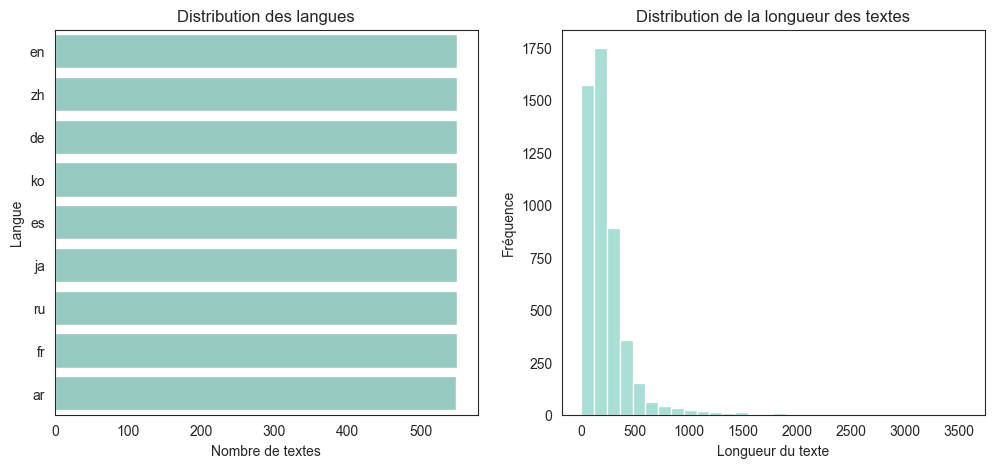

In [101]:
print(analyze_text_length(data))
plot_distributions(data)

### Analyse des Statistiques de Longueur des Textes
- **Count**: 4948 textes ont été analysés, donnant une bonne taille d'échantillon pour des analyses statistiques robustes.
- **Mean**: La longueur moyenne des textes est de 230.24 caractères. Cela indique une tendance vers des textes modérément courts.
- **Std (Standard Deviation)**: L'écart-type est de 221.81, ce qui suggère une variation très considérable dans la longueur des textes, indiquant une distribution large.
- **Min**: Le texte le plus court fait seulement 3 caractères, ce qui pourrait être insuffisant pour certaines analyses linguistiques ou de traitement de texte.
- **25% (1st Quartile)**: 25% des textes ont 103 caractères ou moins.
- **50% (Median)**: La médiane est à 179 caractères, soulignant que la moitié des textes sont assez courts.
- **75% (3rd Quartile)**: 75% des textes ont 280 caractères ou moins.
- **Max**: Le texte le plus long a 3558 caractères, montrant qu'il y a des cas où les textes sont significativement plus longs.

### Interprétation Visuelle (Graphique)
- **Distribution de la longueur des textes** : La majorité des textes sont concentrés dans les premières barres du graphique, avec une longueur de moins de 500 caractères, ce qui correspond à la description de la médiane et des quartiles. Cela montre que la plupart des textes sont relativement courts, ce qui est normal puisque chaque texte ne comprend au maximum que 2 phrases, bien que la présence de quelques textes extrêmement longs étende la distribution vers la droite.


In [102]:
def remove_text_length_outliers(data: pd.DataFrame) -> pd.DataFrame:
    """
    Supprime les outliers basés sur la longueur des textes dans le DataFrame.

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à nettoyer

    Returns:
    pd.DataFrame: Le DataFrame nettoyé sans les outliers
    """
    data_copy = data.copy()

    # Calcul de la longueur des textes et assignation en utilisant .loc pour éviter SettingWithCopyWarning
    data_copy.loc[:, "Text_Length"] = data_copy["Text"].apply(len)

    # Calcul de l'écart interquartile (IQR)
    Q1 = data_copy["Text_Length"].quantile(0.25)
    Q3 = data_copy["Text_Length"].quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes pour les outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrage des données pour éliminer les outliers
    filtered_data = data_copy[
        (data_copy["Text_Length"] >= lower_bound)
        & (data_copy["Text_Length"] <= upper_bound)
    ]

    # Sauvegarde des données nettoyées
    filtered_data.to_csv("../../data/csv/data_cleaned.csv", index=False)

    return filtered_data

In [103]:
filtered_data = remove_text_length_outliers(data)
print(analyze_text_length(filtered_data))


print("------------------------------\n", analyze_language_distribution(filtered_data))

count    4678.000000
mean      190.606670
std       114.600034
min         3.000000
25%       100.000000
50%       170.000000
75%       259.000000
max       544.000000
Name: Text_Length, dtype: float64
------------------------------
 Label
zh    550
de    550
ja    550
ko    548
en    539
ru    539
fr    539
es    527
ar    336
Name: count, dtype: int64


Après la suppression des valeurs aberrantes, le nombre de texte pour l'arabe à diminuer de 548 à 336, 

In [104]:
def augment_underrepresented_labels(
    data: pd.DataFrame, label_col: str, text_col: str, threshold: int
) -> pd.DataFrame:
    """
    Augmente les étiquettes sous-représentées dans un DataFrame en utilisant SMOTE.

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les colonnes de texte et d'étiquettes.
    label_col (str): Le nom de la colonne contenant les étiquettes.
    text_col (str): Le nom de la colonne contenant les textes.
    threshold (int): Le seuil minimal du nombre d'échantillons par étiquette.

    Returns:
    pd.DataFrame: Le DataFrame augmenté.
    """
    # Obtenir le nombre d'échantillons par étiquette
    label_counts = data[label_col].value_counts()

    # Créer une stratégie de sur-échantillonnage pour les étiquettes sous-représentées
    sampling_strategy = {
        label: threshold for label, count in label_counts.items() if count < threshold
    }

    # Vérifier si des étiquettes sous-représentées existent
    if not sampling_strategy:
        print("Aucune étiquette sous-représentée trouvée.")
        return data

    # Convertir le texte en vecteurs numériques
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data[text_col])
    y = data[label_col]

    # Utiliser SMOTE pour augmenter les étiquettes sous-représentées
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Convertir les données augmentées en DataFrame
    X_resampled = vectorizer.inverse_transform(
        X_resampled
    )  # Convertir les vecteurs TF-IDF en textes
    augmented_data = pd.DataFrame(
        {text_col: [" ".join(text) for text in X_resampled], label_col: y_resampled}
    )

    return augmented_data

Label
ar    550
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
Name: count, dtype: int64


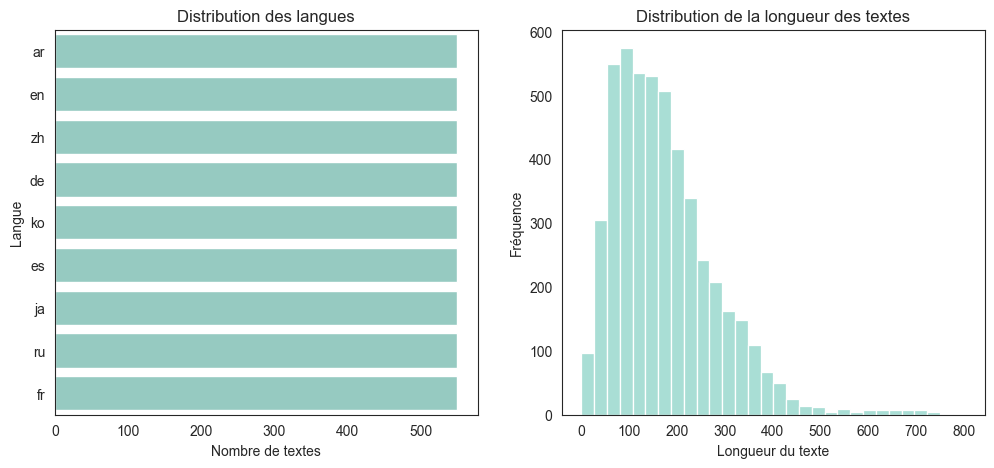

In [105]:
# Utiliser la fonction pour augmenter les étiquettes ayant moins de 550 échantillons
augmented_data = augment_underrepresented_labels(filtered_data, "Label", "Text", 550)

augmented_data.to_csv("../../data/csv/augmented_data.csv", index=False)

# Vérifier la nouvelle distribution des étiquettes
print(augmented_data["Label"].value_counts())

analyze_text_length(augmented_data)

plot_distributions(augmented_data)

In [106]:
def split_train_dev_test(
    csv_path: str,
    folder_csv: str,
    label_column: str,
    train_size: float = 0.7,
    dev_size: float = 0.15,
    random_state: int = 42,
) -> None:
    """
    Cette fonction prend un fichier CSV d'entrée, le divise en ensembles d'entraînement, de développement (dev),
    et de test, et équilibre les classes dans chaque ensemble.

    Parameters:
    - csv_path (str): Le chemin du fichier CSV à charger
    - folder_csv (str): Le dossier de sortie pour les fichiers CSV
    - label_column (str): Le nom de la colonne contenant les étiquettes
    - train_size (float): La proportion de l'ensemble d'entraînement (ex: 0.7 pour 70%)
    - dev_size (float): La proportion de l'ensemble de développement
    - random_state (int): Le générateur de nombres aléatoires pour la reproductibilité

    Returns:
    - None
    """
    # Charger les données depuis le fichier CSV
    data = pd.read_csv(csv_path)

    # Calculer la proportion de l'ensemble de test
    test_size = 1.0 - train_size

    # Diviser les données en ensembles d'entraînement et (dev + test)
    df_train, df_dev_test = train_test_split(
        data, train_size=train_size, random_state=random_state
    )

    # Calculer la proportion de l'ensemble dev dans les données restantes
    dev_proportion = dev_size / (1.0 - train_size)

    # Diviser l'ensemble (dev + test) en ensembles de développement et de test
    df_dev, df_test = train_test_split(
        df_dev_test, train_size=dev_proportion, random_state=random_state
    )

    # Identifier la classe majoritaire dans l'ensemble d'entraînement
    majority_class = df_train[label_column].mode()[0]

    # Fonction d'équilibrage des classes
    def balance_classes(df, majority_class):
        balanced_df = pd.DataFrame()
        for label in df[label_column].unique():
            class_subset = df[df[label_column] == label]
            balanced_subset = resample(
                class_subset,
                replace=True,
                n_samples=len(df[df[label_column] == majority_class]),
                random_state=random_state,
            )
            balanced_df = pd.concat([balanced_df, balanced_subset])
        return balanced_df

    # Équilibrer les classes pour les ensembles d'entraînement, de développement, et de test
    balanced_train = balance_classes(df_train, majority_class)
    balanced_dev = balance_classes(df_dev, majority_class)
    balanced_test = balance_classes(df_test, majority_class)

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(folder_csv, exist_ok=True)

    # Exporter les ensembles d'entraînement, de développement, et de test en fichiers CSV
    balanced_train.to_csv(
        os.path.join(folder_csv, "data_train.csv"), index=False, encoding="utf-8"
    )
    balanced_dev.to_csv(
        os.path.join(folder_csv, "data_dev.csv"), index=False, encoding="utf-8"
    )
    balanced_test.to_csv(
        os.path.join(folder_csv, "data_test.csv"), index=False, encoding="utf-8"
    )

    return balanced_train, balanced_dev, balanced_test

In [107]:
train_df, dev_df, test_df = split_train_dev_test(
    csv_path="../../data/csv/augmented_data.csv",
    folder_csv="../../data/csv/",
    label_column="Label",
    train_size=0.7,
    dev_size=0.15,
    random_state=42,
)

In [108]:
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

In [109]:
def clean_none_values(dataset) -> Dataset:
    """
    Remplace les valeurs nulles par une chaîne vide dans la colonne "Text" du dataset.

    Parameters:
    dataset (Dataset): Le dataset à nettoyer

    Returns:
    Dataset: Le dataset nettoyé
    """

    def replace_none(example) -> dict:
        """
        Remplace les valeurs nulles par une chaîne vide dans la colonne "Text" d'un exemple.

        Parameters:
        example (dict): Un exemple du dataset

        Returns:
        dict: L'exemple avec les valeurs nulles remplacées
        """
        if example["Text"] is None:
            example["Text"] = ""
        return example

    return dataset.map(replace_none)

In [110]:
train_dataset = clean_none_values(train_dataset)
dev_dataset = clean_none_values(dev_dataset)
test_dataset = clean_none_values(test_dataset)


label_names = train_dataset.unique("Label")
label_mapping = {label: idx for idx, label in enumerate(label_names)}
print(label_names, "\n", label_mapping)

Map:   0%|          | 0/3573 [00:00<?, ? examples/s]

Map:   0%|          | 0/657 [00:00<?, ? examples/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

['zh', 'ja', 'ru', 'ar', 'en', 'de', 'fr', 'es', 'ko'] 
 {'zh': 0, 'ja': 1, 'ru': 2, 'ar': 3, 'en': 4, 'de': 5, 'fr': 6, 'es': 7, 'ko': 8}


In [111]:
def tokenize_text(batch: dict) -> dict:
    """
    Tokenize les textes et ajoute les étiquettes correspondantes

    Parameters:
    batch (dict): Un batch de données contenant les textes et les étiquettes

    Returns:
    dict: Les textes tokenizés avec les étiquettes correspondantes
    """
    texts = batch["Text"]
    if not all(isinstance(text, str) for text in texts):
        non_str_indices = [
            i for i, text in enumerate(texts) if not isinstance(text, str)
        ]
        print(f"Indices avec des valeurs non textuelles : {non_str_indices}")
        print(f"Valeurs problématiques : {[texts[i] for i in non_str_indices]}")
        raise ValueError("All elements in 'Text' must be strings.")

    tokenized_inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=128
    )
    tokenized_inputs["labels"] = [label_mapping[label] for label in batch["Label"]]
    return tokenized_inputs


def tokenize(text: str) -> list:
    """
    Permet de tokeniser un texte en utilisant le tokenizer d'xlm-roberta-base

    Parameters:
    text (str): le texte à tokeniser

    Returns:
    list: une liste de tokens
    """
    return tokenizer.tokenize(text)

In [112]:
def vocabulary_diversity(data: pd.DataFrame) -> pd.Series:
    """
    Calcule la diversité du vocabulaire

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La diversité du vocabulaire pour chaque label/langue
    """
    data["Tokens"] = data["Text"].apply(tokenize)
    data["Vocab_Size"] = data["Tokens"].apply(lambda x: len(set(x)))
    return data.groupby("Label")["Vocab_Size"].mean()

In [113]:
# Tokenization des données
tok_train = train_dataset.map(tokenize_text, batched=True)
tok_valid = valid_dataset.map(tokenize_text, batched=True)
tok_test = test_dataset.map(tokenize_text, batched=True)

# Verifier les tokens
tokens = tokenizer.convert_ids_to_tokens(tok_train[0]["input_ids"])
# print(tokens)

# augmented_data = pd.read_csv("../../data/csv/augmented_data.csv")

vocab_diversity = vocabulary_diversity(augmented_data)
print(vocab_diversity)

Map:   0%|          | 0/3573 [00:00<?, ? examples/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Label
ar    68.321818
de    39.083636
en    42.172727
es    47.307273
fr    42.161818
ja    45.412727
ko    54.625455
ru    46.014545
zh    40.561818
Name: Vocab_Size, dtype: float64


In [114]:
tok_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tok_valid.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tok_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(train_dataset.unique("Label"))
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
epochs = 2
lr = 2e-5
train_bs = 64
eval_bs = train_bs * 2

# Log de l'entraînement à chaque epoch
logging_steps = len(tok_train) // train_bs

# Dossier de sauvegarde des modèles
output_dir = "../../results/model"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    learning_rate=lr,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=eval_bs,
    evaluation_strategy="epoch",
    logging_steps=logging_steps,
    save_strategy="epoch",  # Sauvegarde à la fin de chaque epoch
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train,
    eval_dataset=tok_valid,
)

### TrainingArguments

`TrainingArguments` est une classe fournie par la bibliothèque `transformers` qui est utilisée pour encapsuler tous les arguments et configurations nécessaires pour l'entraînement, l'évaluation, et le test de modèles de traitement automatique du langage naturel (NLP). Voici les paramètres spécifiés dans votre script :

- **`output_dir`** : Le répertoire où les modèles entraînés, les configurations et les logs seront sauvegardés. C'est le chemin du dossier où vous souhaitez que les résultats de l'entraînement soient stockés.

- **`num_train_epochs`** : Le nombre d'epoch pour lesquelles le modèle sera entraîné. Une epoch correspond à un passage complet sur l'ensemble des données d'entraînement.

- **`learning_rate`** : Le taux d'apprentissage utilisé pour l'optimisation pendant l'entraînement. C'est un paramètre crucial qui peut influencer la rapidité et l'efficacité avec laquelle un modèle apprend.

- **`per_device_train_batch_size`** : La taille du lot (batch size) pour l'entraînement. Cela détermine le nombre d'exemples de formation traités avant que le modèle n'effectue une mise à jour des paramètres (backpropagation).

- **`per_device_eval_batch_size`** : La taille du lot pour l'évaluation. C'est similaire à `per_device_train_batch_size` mais utilisé pendant les phases de validation ou d'évaluation.

- **`evaluation_strategy`** : Détermine à quelle fréquence l'évaluation doit avoir lieu. Ici, "epoch" signifie que l'évaluation se produit à la fin de chaque epoch d'entraînement.

- **`logging_steps`** : Nombre de pas d'entraînement après lesquels les logs de progression doivent être enregistrés. Cela aide à suivre la progression et les performances du modèle durant l'entraînement.

- **`save_strategy`** : Stratégie pour sauvegarder le modèle. "epoch" signifie que le modèle est sauvegardé à la fin de chaque epoch, ce qui est utile pour ne pas perdre les progrès en cas d'interruption de l'entraînement.

- **`save_total_limit`** : Le nombre maximal de fichiers de modèle à conserver. Si le nombre de points de sauvegarde dépasse cette limite, les anciens fichiers de sauvegarde sont supprimés.

### Trainer

La classe `Trainer` est utilisée pour encapsuler le processus d'entraînement, en utilisant les configurations définies dans `TrainingArguments`.

- **`model`** : Le modèle pré-entraîné (ici probablement un modèle de classification de séquences) qui sera finement ajusté sur les données spécifiques.

- **`args`** : Les arguments d'entraînement encapsulés par `TrainingArguments`.

- **`train_dataset`** : L'ensemble de données d'entraînement sur lequel le modèle sera entraîné.

- **`eval_dataset`** : L'ensemble de données d'évaluation utilisé pour évaluer les performances du modèle à chaque epoch, conformément à la stratégie d'évaluation définie.

Cette configuration garantit que le modèle est entraîné de manière efficace et que les performances sont régulièrement évaluées et sauvegardées, permettant un ajustement optimal et une récupération facile des modèles entraînés.

In [116]:
trainer.train()

  0%|          | 0/112 [00:00<?, ?it/s]

{'loss': 1.4568, 'grad_norm': 7.689733028411865, 'learning_rate': 1.0178571428571429e-05, 'epoch': 0.98}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3504881262779236, 'eval_runtime': 5.6468, 'eval_samples_per_second': 116.348, 'eval_steps_per_second': 1.063, 'epoch': 1.0}
{'loss': 0.4376, 'grad_norm': 3.1403231620788574, 'learning_rate': 3.5714285714285716e-07, 'epoch': 1.96}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.1293065994977951, 'eval_runtime': 5.3105, 'eval_samples_per_second': 123.717, 'eval_steps_per_second': 1.13, 'epoch': 2.0}
{'train_runtime': 231.0425, 'train_samples_per_second': 30.929, 'train_steps_per_second': 0.485, 'train_loss': 0.9355697504111699, 'epoch': 2.0}


TrainOutput(global_step=112, training_loss=0.9355697504111699, metrics={'train_runtime': 231.0425, 'train_samples_per_second': 30.929, 'train_steps_per_second': 0.485, 'total_flos': 470077442993664.0, 'train_loss': 0.9355697504111699, 'epoch': 2.0})

In [117]:
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

  0%|          | 0/6 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.1293065994977951, 'eval_runtime': 5.3389, 'eval_samples_per_second': 123.058, 'eval_steps_per_second': 1.124, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          zh       1.00      1.00      1.00        80
          ja       1.00      1.00      1.00        80
          ru       1.00      1.00      1.00        80
          ar       1.00      1.00      1.00        80
          en       0.99      1.00      0.99        80
          de       1.00      1.00      1.00        80
          fr       1.00      0.99      0.99        80
          es       1.00      1.00      1.00        80
          ko       1.00      1.00      1.00        80

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



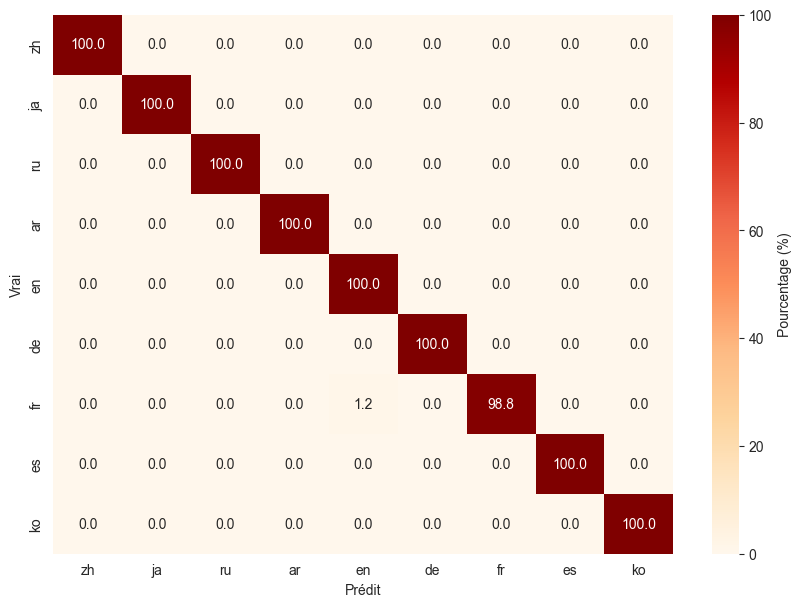

<Figure size 640x480 with 0 Axes>

In [118]:
predictions = trainer.predict(tok_test)
preds = predictions.predictions.argmax(-1)
labels = tok_test["Label"]

# Convertir les labels en entiers
int_labels = [label_mapping[label] for label in labels]

label_names = [
    label for label, index in sorted(label_mapping.items(), key=lambda item: item[1])
]

print(classification_report(int_labels, preds, target_names=label_names))

# Créer la matrice de confusion
cm = confusion_matrix(int_labels, preds)

# Calculer les pourcentages
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Création de la figure pour la visualisation
plt.figure(figsize=(10, 7))

# Utilisation de seaborn pour tracer la heatmap
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",  # Format à un chiffre décimal
    xticklabels=sorted(
        label_mapping, key=label_mapping.get
    ),  # Étiquettes pour les prédictions
    yticklabels=sorted(
        label_mapping, key=label_mapping.get
    ),  # Étiquettes pour les vrais labels
    cmap="OrRd",
    cbar_kws={"label": "Pourcentage (%)"},  # Barre de couleur avec étiquette
)

plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()
plt.savefig("../../results/confusion_matrix.png")

### Matrice de Confusion
La matrice de confusion mise à jour montre les pourcentages de prédictions correctes et incorrectes pour un modèle de classification linguistique multilingue. Chaque ligne représente les vraies étiquettes (langues réelles des textes), et chaque colonne représente les prédictions du modèle. Voici une interprétation détaillée basée sur la nouvelle matrice de confusion et des métriques de performance associées :

#### Analyse de la Matrice de Confusion

- **Diagonales Principales** : Les valeurs sur la diagonale principale de la matrice indiquent le pourcentage de prédictions correctes pour chaque langue. Par exemple, le modèle a correctement identifié 100% des textes en chinois (`zh`), japonais (`ja`), russe (`ru`), arabe (`ar`), anglais (`en`), allemand (`de`), espagnol (`es`) et coréen (`ko`).
  
- **Précisions Notables** :
  - **Français (`fr`)** : Le modèle a correctement prédit 98,8% des textes français. Il y a une petite confusion avec l'anglais (`en`), où 1,2% des textes français ont été incorrectement classés comme anglais.

#### Interprétation des Résultats

- **Haute Précision Globale** : La majorité des langues ont une précision de 100%, ce qui signifie que le modèle est extrêmement précis pour ces langues. Cela indique une forte capacité du modèle à distinguer ces langues des autres dans l'ensemble de données.

- **Légère Confusion entre le Français et l'Anglais** : La confusion entre le français et l'anglais pourrait être due à des similarités linguistiques, comme l'utilisation de mots empruntés ou de structures grammaticales similaires, qui peuvent induire le modèle en erreur dans certains cas. Ce point pourrait nécessiter une investigation plus approfondie pour améliorer la précision du modèle, par exemple en ajustant les données d'entraînement ou en optimisant les hyperparamètres du modèle pour mieux gérer les similitudes entre ces deux langues.

### Métriques de Performance
- **Précision** : La précision mesure la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif. Pour toutes les langues sauf l'anglais et le français, la précision est de 1,00, ce qui signifie que chaque instance prédite comme appartenant à cette langue était correcte. L'anglais a une précision légèrement inférieure à 1,00 en raison d'une instance de français incorrectement classifiée comme anglais.
  
- **Rappel** : Le rappel mesure la capacité du classificateur à trouver tous les échantillons positifs. Par exemple, le rappel pour le français est de 0,99 parce qu'une instance de français a été classée comme anglais, manquant donc une instance correcte.

- **F1-Score** : Le F1-score est la moyenne harmonique de la précision et du rappel. Il est particulièrement utile lorsque les classes sont déséquilibrées. Les F1-scores sont excellents pour toutes les langues, reflétant une performance équilibrée entre la précision et le rappel.

- **Support** : Le support est le nombre de occurrences réelles de la classe dans l'ensemble de données spécifié. Chaque langue avait 80 instances dans ce dataset.

### Résumé Global
- **Précision Globale (Accuracy)** : Le modèle a atteint une précision globale de 1,00, indiquant une excellente performance globale sur cet ensemble de données.
- **Moyenne Macro** : La moyenne macro de précision, rappel, et F1-score est de 1,00 pour chaque métrique, indiquant une performance uniformément élevée à travers toutes les classes linguistiques.

Cette matrice de confusion et ces métriques de performance démontrent que le modèle de classification est extrêmement précis et performant dans la classification des langues de cet ensemble de données, avec une légère confusion entre le français et l'anglais qui pourrait nécessiter une investigation plus approfondie pour des améliorations futures.

In [119]:
model.save_pretrained("../../data/model/model/")
tokenizer.save_pretrained("../../data/model/tokenizer")

('../../data/model/tokenizer/tokenizer_config.json',
 '../../data/model/tokenizer/special_tokens_map.json',
 '../../data/model/tokenizer/tokenizer.json')